# Spectral graph theory and Expectation-Maximization (EM) algorithm

### Theoretical background

For EM algorithm applied in clustering graph, we first have to embedded the graph into a cartesian coordinate.
Embedded the graph into a cartesian coordinate, we applied the spectral graph embeding.

defind the Laplacian matrix as $L= D-A$ where $L$ is the laplacian $D$ is the degree matrix and $A$ is the adjacency matrix.

to embed the graph into $R^2$ first we do eigenvalue decomposition for the Laplacian opperator. After embedding graph into cartesian, we use EM algorithm to cluster graph.

Since the Laplacian opperator is symmetrix, we have the following relation:
$$\lambda= \frac{X^T*L*X}{X^T*X} $$

where X is the corresponding eigen vector. Also, we want to normalize $X$ so that $X^T*X=1$

so then
$$
        \lambda= \displaystyle\sum_{i,j=1}^n X_i*L_{i,j}*X_j
               = \displaystyle\sum_{i,j=1}^n X_i*(D_{i,j}-A_{i,j})*X_j
               =\displaystyle\sum_i^n D_{i,i}*X_i^2 -2*\displaystyle\sum_{(i,j)\in E} X_i*X_j
               = \displaystyle\sum_{(i,j)\in E} (X_i-X_j)^2
$$

we can think $X$ as a label vector and by choosing the smallest eigenvalue, we are minimize the label assign hence 

mapping at $R^n$

In [1]:
# imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import sklearn as sk
import pandas as pd

from scipy.linalg import eig, eigh

from clustering_util import ASE, LSE, cluster_member, GMM_cluster, averaging_cluster, coclustering_trials

# testing at what conditon will the 2 true cluster will coincide

In [ ]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython import display
sizes2 = [2*20, 2*30]
n_nodes = np.sum(sizes2)
model= GaussianMixture(n_components=2, init_params='random',n_init= 50)

probs_test = [[ 0, 0], [ 0, 0]]
g2 = nx.stochastic_block_model(sizes2, probs_test, seed=1)
true_cluster_test= np.hstack([[i]*s for i,s in enumerate(sizes2)])
t=0

true_matrix=np.zeros((len(g2),len(g2)))

aa_vals = [0.01, 0.05, 0.10]
bb_vals = [0.01, 0.05, 0.10]

ab_vals = np.linspace(0, 0.1, 11)


plt.figure(figsize=(10,10), tight_layout="tight")
for p, aa in enumerate(aa_vals):    
    for q, bb in enumerate(bb_vals):
        error=[]
        for r, ab in enumerate(ab_vals):
            probs_test[0][0]=aa            
            probs_test[1][0]=ab
            probs_test[0][1]=probs_test[1][0]
            probs_test[1][1]=bb
            g2= nx.stochastic_block_model(sizes2, probs_test, seed=1)            
            L2=np.zeros((len(g2),len(g2)))
            
            for i, v in enumerate(g2.nodes):
                L2[i,i]=g2.degree(v)
#             for l in range(len(g2)):
#                     L2[l,l]=g2.degree(l)
            
            L2=L2-nx.adjacency_matrix(g2)
            
            eig2, eigvec2= np.linalg.eigh(L2)
            p2=eigvec2[:,[1,2]]
            
            
#             plt.subplot(1,2,1)
#             plt.xlim(-1,1)
#             plt.ylim(-1,1)
#             plt.title("EM algorishm")
            em_label=GMM_cluster(p2)
#             plt.scatter([p2[:,0]],[p2[:,1]], c=em_label, alpha=0.5)
            
            
#             plt.subplot(1,2,2)
            
#             plt.xlim(-1,1)
#             plt.ylim(-1,1)
#             plt.title(f"aa ={aa}, ab ={ab},bb = {bb}")
#             plt.scatter([p2[:,0]],[p2[:,1]], c= true_cluster_test, alpha=0.5)
            EM_matrix=np.zeros((len(g2),len(g2)))
            

            EM_matrix= cluster_member(em_label)

            true_matrix= cluster_member(true_cluster_test)
                        
            error.append((EM_matrix!=true_matrix).sum() / (n_nodes * (n_nodes - 1)))
            
        "Error plot of the Error matrix"
        plt.subplot(len(aa_vals),len(bb_vals),p*len(aa_vals) + q + 1)
        plt.title(f"aa={aa}, bb={bb}")
        plt.xlabel("ab")
        plt.ylabel("Error Rate")
        plt.plot(ab_vals, error)
          
    

#             plt.pause(0.0001)
#             plt.show()
#             plt.clf()



depend on the path that could affect the correctiveness. if ab increase then the error increase. if aa and bb increase then the error is decrease

In [ ]:
# %matplotlib inline

# plt.figure(figsize=(10,5))
# plt.title("error with chosen path")
# plt.ylabel("error")
# plt.xlabel("bb")
# plt.plot(np.linspace(0,0.1,11),np.array(error))


In [ ]:
probs_test = [[ .3, .1], [ 0.1, 0.4]]
g2 = nx.stochastic_block_model(sizes2, probs_test, seed=1)

for i, v in enumerate(g2.nodes):
    L2[i,i]=g2.degree(v)

    L2=L2-nx.adjacency_matrix(g2)
    
    eig2, eigvec2= np.linalg.eigh(L2)
    p2=eigvec2[:,[1,2]]
    
plt.plot(range(len(eig2)),eig2)

In [ ]:
L3=nx.adjacency_matrix(g2)
eig1, eigvec1= np.linalg.eigh(L2)
plt.plot(range(len(eig1)),eig1)

In [ ]:
from ipywidgets.widgets import Label, FloatProgress, FloatSlider, Button, Layout, HBox, VBox
from IPython.display import display
import bqplot as bq
import time
import threading


In [ ]:
wA= FloatSlider(
    min=0.1,
    max= 1,
    value= 0,
    step=0.01,
    description = 'aa'
)

wAB= FloatSlider(
    value= 0,
    min=0,
    max= 1,
    step=0.01,
    description = 'ab'
)

wB= FloatSlider(
    value= 0,
    min=0,
    max= 1,
    step=0.01,
    description = 'bb'
)

join= HBox(
    children=(wA, wAB, wB),
    layout= Layout(margin= '0 0 0 43px')
)

In [ ]:
aa= wA.value
ab=wAB.value
bb=wB.value

In [ ]:
%matplotlib inline
probs_test = [[ aa, ab], [ ab, bb]]
sizes2 = [2*20, 2*30]
g2 = nx.stochastic_block_model(sizes2, probs_test, seed=1)
L2=np.zeros((len(g2),len(g2)))
true_cluster_test= np.hstack([[i]*s for i,s in enumerate(sizes2)])
color=["blue", "red"]
true_cluster_test_color=np.array(color)[true_cluster_test]


for i, v in enumerate(g2.nodes):
            L2[i,i]=g2.degree(v)
            L2=L2-nx.adjacency_matrix(g2)
            
            eig2, eigvec2= np.linalg.eigh(L2)
            p2=eigvec2[:,[1,2]]

In [ ]:

xs= bq.LinearScale()
ys= bq.LinearScale()
x=np.array(p2[:,0]).flatten()
y=np.array(p2[:,1]).flatten()

scatt= bq.Scatter(x=x,y=y, scales={'x': xs, 'y': ys}, colors=true_cluster_test_color.tolist())

xax=bq.Axis(scale=xs, label='x', grid_lines= 'solid')

yax=bq.Axis(scale=ys, orientation= 'vertical', tick_format='0.02f',label='y', grid_lines= 'solid')

fig=bq.Figure(marks=[scatt], axes=[xax,yax], animation_duration=1000, title="true label", layout= Layout(width= '500px', height='300px'))



In [ ]:


x=np.array(p2[:,0]).flatten()
y=np.array(p2[:,1]).flatten()

scatt2= bq.Scatter(x=x,y=y, scales={'x': xs, 'y': ys})
fig1=bq.Figure(marks=[scatt2], axes=[xax,yax], animation_duration=1000, title="EM label", layout= Layout(width= '500px', height='300px'))




In [ ]:

import bqplot.pyplot as bqplt
from bqplot import *
xxs= bq.LinearScale(min=-1, max=1)
yys= bq.LinearScale(min=-1, max=1)

xxaxx=bq.Axis(scale=xxs, label='x', grid_lines= 'solid')

yyaxx=bq.Axis(scale=yys, orientation= 'vertical', tick_format='0.02f',label='y', grid_lines= 'solid')



xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100)
color_heat = nx.to_numpy_array(g2)

heat=bqplt.heatmap(color= color_heat, x=xx, y=yy)

fig3=bq.Figure(marks=[heat], axes=[xxaxx,yyaxx], animation_duration=1000, title="adjacency matrix", layout= Layout(width= '300px', height='300px'))

In [ ]:
box=HBox(
    children=[fig,fig1]
)
box1=VBox(
    children=[box,fig3]
)

box2=VBox(
    children=[box1, join]
)


In [ ]:
def GUI():
    global x
    global y
    while True:
        aa= wA.value
        ab=wAB.value
        bb=wB.value 
        probs_test = [[ aa, ab], [ ab, bb]]
        sizes2 = [2*20, 2*30]
        g2 = nx.stochastic_block_model(sizes2, probs_test, seed=1)
        L2=np.zeros((len(g2),len(g2)))
        
        heat.color= nx.to_numpy_array(g2)
        for i, v in enumerate(g2.nodes):
            L2[i,i]=g2.degree(v)
            L2=L2-nx.adjacency_matrix(g2)
            
        eig2, eigvec2= np.linalg.eigh(L2)
        p2=eigvec2[:,[1,2]]
        
        
        em_label=model.fit(p2)
        em_label=em_label.predict(p2)
        em_color_test=np.array(color)[em_label]
        x=np.array(p2[:,0]).flatten()
        y=np.array(p2[:,1]).flatten()


            
        scatt.x=np.array(p2[:,0]).flatten()
        scatt.y=np.array(p2[:,1]).flatten()
        scatt2.x=scatt.x
        scatt2.y=scatt.y
        scatt2.colors=em_color_test.tolist()
        
        

        

In [ ]:

thread= threading.Thread(target=GUI)

display(box2)
thread.start()


# averaging clustering from different clustering method

In [21]:
# A quick visualization of a single example
sizes2 = [2*20, 2*30]
n_nodes = sum(sizes2)
aa, ab, bb = 0.4, 0.2, 0.25
C_true = [[aa, ab], [ab, bb]]  # define the parameters of the stochastic block model
k_true = np.hstack([[i]*s for i,s in enumerate(sizes2)])  # True cluster label vector

g2 = nx.stochastic_block_model(sizes2, C_true)  # generate a random graph

pA = ASE(g2)
pL = LSE(g2)

k_ASEGMM = GMM_cluster(pA.T)
k_LSEGMM = GMM_cluster(pL.T)

print("p_AA =", aa)
print("p_AB =", ab)
print("p_BB =", bb)

p_AA = 0.4
p_AB = 0.2
p_BB = 0.25


In [28]:
last_node = -1
g2.add_node(last_node)
g2.add_edges_from([(-1, a) for a in np.random.choice(range(sizes2[0]), size=10, replace=False)])
g2.add_edges_from([(-1, b) for b in np.random.choice(range(sizes2[0], sizes2[0] + sizes2[1]), size=10, replace=False)])

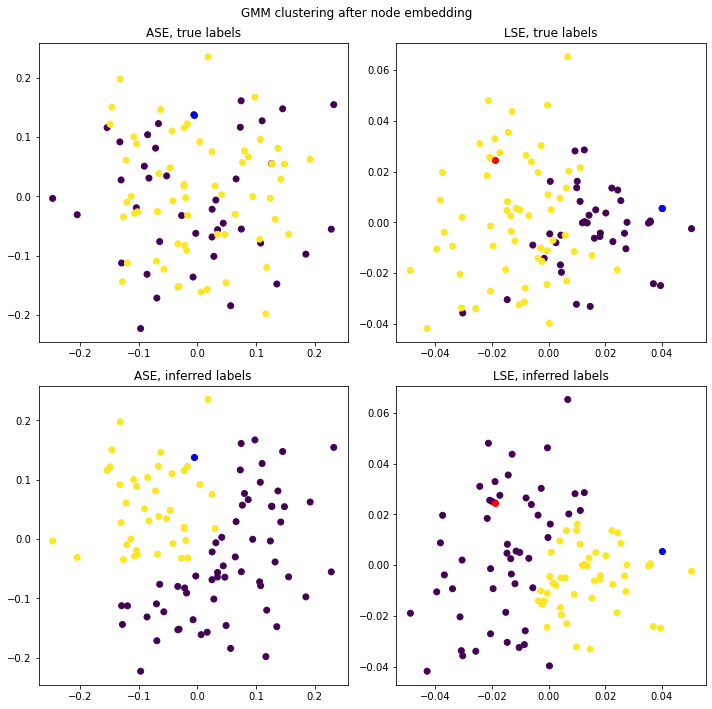

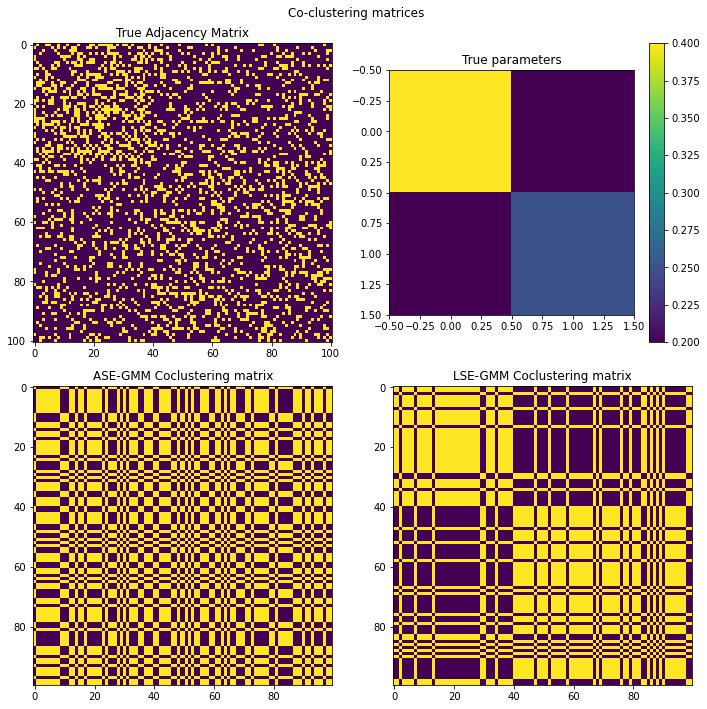

In [31]:
node = 50

plt.figure(figsize=(10,10), tight_layout="tight")
plt.suptitle("GMM clustering after node embedding")
plt.subplot(2,2,1)
plt.scatter(pA[0], pA[1], c=k_true)
plt.title("ASE, true labels")
plt.scatter([pA[0,0]], [pA[1,0]], c="blue")

plt.subplot(2,2,2)
plt.scatter(pL[0], pL[1], c=k_true)
plt.title("LSE, true labels")
plt.scatter([pL[0, node]], [pL[1, node]], c="red")
plt.scatter([pL[0,0]], [pL[1,0]], c="blue")

plt.subplot(2,2,3)
plt.scatter(pA[0], pA[1], c=k_ASEGMM)
plt.title("ASE, inferred labels")
plt.scatter([pA[0,0]], [pA[1,0]], c="blue")

plt.subplot(2,2,4)
plt.scatter(pL[0], pL[1], c=k_LSEGMM)
plt.title("LSE, inferred labels")
plt.scatter([pL[0, node]], [pL[1, node]], c="red")
plt.scatter([pL[0,0]], [pL[1,0]], c="blue")

plt.figure(figsize=(10,10), tight_layout="tight")
plt.suptitle("Co-clustering matrices")
plt.subplot(2,2,1)
plt.title("True Adjacency Matrix")
plt.imshow(nx.adjacency_matrix(g2).todense(), interpolation="none")

plt.subplot(2,2,2)
plt.title("True parameters")
plt.imshow(C_true, interpolation="none")
plt.colorbar()

plt.subplot(2,2,3)
plt.title("ASE-GMM Coclustering matrix")
plt.imshow(cluster_member(k_ASEGMM), interpolation="none")

plt.subplot(2,2,4)
plt.title("LSE-GMM Coclustering matrix")
plt.imshow(cluster_member(k_LSEGMM), interpolation="none")

In [33]:
n_trials = 50
# C_all = np.zeros((n_trials, n_nodes, n_nodes))
# k_all = np.zeros((n_trials, n_nodes))
# C_avg = averaging_cluster(g2, times=n_trials, embeding=LSE, return_labels=k_all, coclusters=C_all)
k_all, C_all = coclustering_trials(g2, n_trials, embedding=LSE)
C_avg = C_all.mean(axis=0)

(0.0, 1.0)

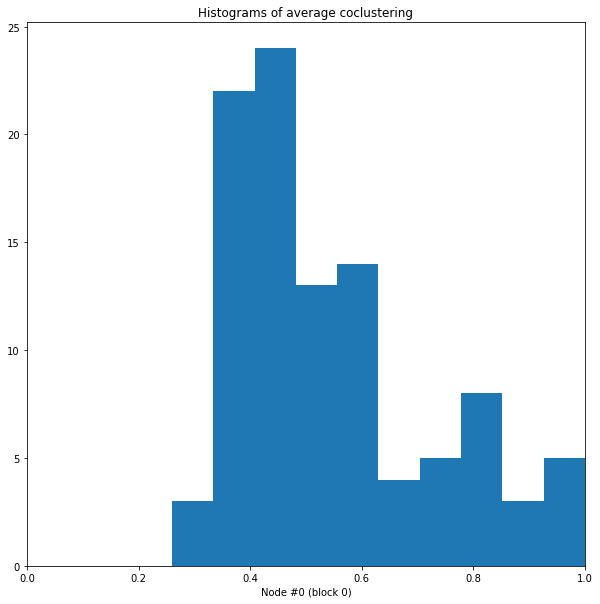

In [34]:
plt.figure(figsize=(10,10))
plt.title("Histograms of average coclustering")
# for row in C_avg:
#     plt.hist(row, density=True, alpha=0.5)
node = 0
plt.hist(C_avg[node])
plt.xlabel(f"Node #{node:d} (block {k_true[node]})")

plt.xlim(0,1)

Text(0.5, 0, 'Coclustering')

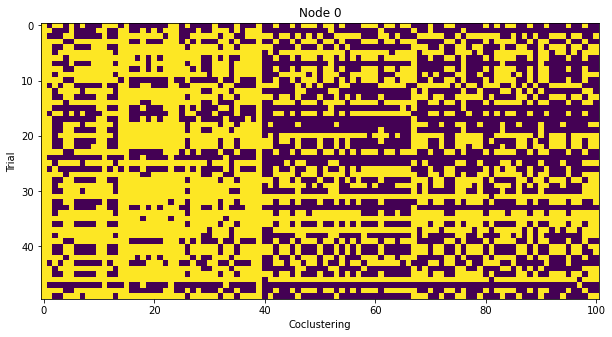

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(C_all[:,node,:], interpolation="none")
plt.title("Node "+str(node))
plt.ylabel("Trial")
plt.xlabel("Coclustering")

<BarContainer object of 101 artists>

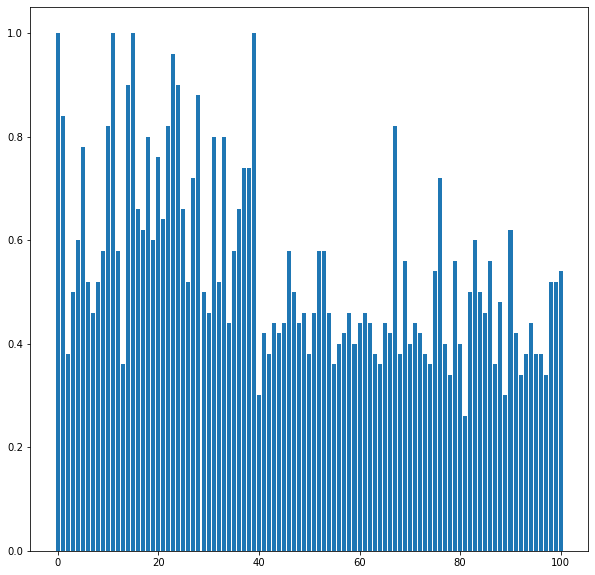

In [42]:
plt.figure(figsize=(10,10))
plt.bar(range(n_nodes+1), C_all[:,node,:].mean(axis=0))